# Machine Learning Classifier Evaluation

Fit a range of ML classifiers to each subject in the NAGL study, and create a tbale of metrics, including mean accuracy from 10-fold stratified corss-validation, and generalization accuracy of the model to a test set (20% of original data).

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns

from glob import glob
from pathlib import Path
import yaml
from yaml import CLoader as Loader
import os.path as op

import mne
from mne import io, EvokedArray

from mne.decoding import Vectorizer, get_coef
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score

from mne.decoding import LinearModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# import a linear classifier from mne.decoding
# from mne.decoding import CSP

mne.set_log_level(verbose='Warning')

## Read config file

In [2]:
bids_root = '../..'

cfg_file = op.join(bids_root, 'config.yml')
with open(cfg_file, 'r') as f:
    config = yaml.load(f, Loader=Loader)

study_name = config['study_name']
task = config['task']
data_type = config['data_type']
eog = config['eog']
montage_fname = config['montage_fname']
n_jobs = config['n_jobs']

cl_p = {k: v for d in config['classification'] for k, v in d.items()}
# epoch_p =  {k: v for d in config['analysis_settings'] for k, v in d.items()}

# baseline = eval(epoch_p['baseline'])

# comp =  {k: v for d in config['components'] for k, v in d.items()}

# components = {}
# for c, p in comp.items():
#     tmp = {}
#     for i in p:
#         for k, v in i.items():
#             tmp[k] = v
#     components[c] = tmp    

In [3]:
# n_jobs = 12

## Paths

In [4]:
source_path = op.join(bids_root, 'derivatives', 'erp_preprocessing')

derivatives_path = op.join(bids_root, 'derivatives', 'erp_classification_test_' + str(cl_p['test_size'])[-1] + '0_pct')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)

out_path = op.join(derivatives_path, 'data')
if Path(out_path).exists() == False:
    Path(out_path).mkdir(parents=True)

report_path = op.join(derivatives_path, 'reports')
if Path(report_path).exists() == False:
    Path(report_path).mkdir(parents=True)

fig_path = op.join(derivatives_path, 'figures')
if Path(fig_path).exists() == False:
    Path(fig_path).mkdir(parents=True) 

    
tab_path = op.join(derivatives_path, 'tables')
if Path(tab_path).exists() == False:
    Path(tab_path).mkdir(parents=True) 
    
epochs_suffix = '-epo.fif'

# output files
out_file = op.join(tab_path, 'classification_accuracy_results.csv')
summary_file =  op.join(tab_path, 'classification_accuracy_summary.csv')
plot_stem = op.join(fig_path, 'plot_')
fig_format = 'pdf'

## List of subjects

In [5]:
prefix = 'sub-'
subjects = sorted([s[-7:] for s in glob(source_path + '/' + prefix + '*')])
print("n subjects = ", len(subjects))

n subjects =  5


## Define conditions and labels

In [6]:
conditions = ['Angry/Grey/target', 'Angry/Grey/nontarget',
              'Angry/Red/target', 'Angry/Red/nontarget',
              'Neutral/Grey/target', 'Neutral/Grey/nontarget',
              'Neutral/Red/target', 'Neutral/Red/nontarget',
              'target', 'nontarget'
             ]

coi = ['target', 'nontarget']

contrasts = {'Angry/Grey':['Angry/Grey/target', 'Angry/Grey/nontarget'],
             'Angry/Red':['Angry/Red/target', 'Angry/Red/nontarget'],
             'Neutral/Grey':['Neutral/Grey/target', 'Neutral/Grey/nontarget'],
             'Neutral/Red':['Neutral/Red/target', 'Neutral/Red/nontarget'],
#              'Target-Nontarget':['target', 'nontarget']
            }

## Load in data

In [7]:
epochs = {}
for subject in subjects:
    subj_path = op.join(source_path, subject, 'eeg')
    epochs[subject] = mne.read_epochs(str(subj_path + '/' + subject + '_task-' + task + '-epo.fif'),
                                         verbose=None, 
                                         preload=True)

### Define transformers and classifiers

In [8]:
rng = np.random.RandomState(cl_p['random_state'])
vectorizer = Vectorizer()
scaler = StandardScaler()
logreg = LinearModel(LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=n_jobs, verbose=False, random_state=rng))
lda = LinearDiscriminantAnalysis()
# csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
svc = LinearSVC(C=8, max_iter=10000, verbose=False, random_state=rng) 
rf = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs, verbose=True, random_state=rng)
nb = GaussianNB()

classifiers = {'LR':logreg, 'LDA':lda, 'SVM':svc }  # Extras not needed for Julia's thesis
# For cross-validation
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

## Classification loop
For each subject and condition, fit each classifier and score

In [ ]:
%%time

acc_tab = pd.DataFrame()
acc_tab_list = []

for subject in subjects:
    print('\n-------\n' + subject)
    
    for contr, conds in contrasts.items():
        print('-------\n' + contr)
        subj_epochs = epochs[subject][conds]

        # create a list of labels from event codes mapped to event_id
        event_id_rev = dict(zip(subj_epochs.event_id.values(), subj_epochs.event_id.keys()))
        labels_all = [event_id_rev[e] for e in subj_epochs.events[:, 2]]
        labels_all = pd.DataFrame(labels_all)[0].str.split('/', expand=True).rename(columns={0:'Emotion', 1:'Colour', 2:'Status', 3:'Location'})
        label_map = {'target':1, 'nontarget':0}
        labels_all['labels'] = labels_all['Status'].map(label_map)
        labels = labels_all['labels']

        # Extract data from subj_epochs and vectorize 
        X = subj_epochs.get_data()    

        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, labels,
                                                            stratify=labels,
                                                            test_size=cl_p['test_size'], 
                                                            random_state=42)

        for c_name, c in classifiers.items():
            print('-------\nRunning classifier: ' + c_name)
            clf = Pipeline([('Vectorizer', vectorizer),
                            ('Scaler', scaler),
                            (c_name, c)
                           ])

    #         kf_scores = cross_val_score(clf, X_train, y_train, cv=cv)
            # Fit model then get prediction accuracy on test set
            print('Cross validate...')
            cv_cv = cross_validate(clf, X_train, y_train, 
                                   scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                                   cv=cv,
                                   n_jobs=n_jobs)      
            print('Training...')
            train_fit = clf.fit(X_train, y_train)
            print('Predicting...')
            y_pred = clf.predict(X_test)

            print('Scoring...')
            # test_score = clf.score(X_test, y_test)

            acc_tab_list.append(pd.DataFrame({'participant_id':subject,
                                              'Condition':contr,
                                              'Classifier':c_name,
                                              'CV_accuracy':cv_cv['test_accuracy'].mean().round(3) * 100,
                                              'Test_accuracy':accuracy_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_precision':cv_cv['test_precision'].mean().round(3) * 100,
                                              'Test_precision':precision_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_recall':cv_cv['test_recall'].mean().round(3) * 100,
                                              'Test_recall':recall_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_f1':cv_cv['test_f1'].mean().round(3) * 100,
                                              'Test_f1':f1_score(y_test, y_pred).round(3) * 100,
                                              
                                              'CV_ROC_AUC':cv_cv['test_roc_auc'].mean().round(3) * 100,
                                              'Test_ROC_AUC':roc_auc_score(y_test, y_pred).round(3) * 100,
                                              
                                              'Fit Time':cv_cv['fit_time'].mean().round(3)
                                             }, index=[0]
                                            )
                               )
                            
acc_tab = pd.concat(acc_tab_list)
acc_tab.to_csv(out_file)

- **Architect**: 26 min 25 s
- **Aaron's laptop**: 9 min 55 s

## Full results grouped by participant

This table and the summary (averaged across participants) are saved as CSV files in the `derivatives` folder.

In [10]:
acc_tab.groupby(['participant_id', 'Condition', 'Classifier']).mean()
acc_tab.to_csv(out_file)

CV_accuracy  Test_accuracy  \
participant_id Condition    Classifier                               
sub-001        Angry/Grey   LDA                74.7           71.6   
                            LR                 74.4           72.7   
                            NB                 34.9           32.7   
                            RF                 82.4           82.2   
                            SVM                64.2           66.2   
               Angry/Red    LDA                73.6           71.3   
                            LR                 78.2           73.1   
                            NB                 59.3           56.2   
                            RF                 81.3           80.7   
                            SVM                66.2           62.9   
               Neutral/Grey LDA                74.2           72.9   
                            LR                 72.7           73.8   
                            NB                 61.3           64.4   
                            RF                 82.7           79.6   
                            SVM                64.4           64.9   
               Neutral/Red  LDA                70.2           68.0   
                            LR                 71.8           68.7   
                            NB                 73.1           71.6   
                            RF                 82.4           81.8   
                            SVM                64.7           60.9   
sub-002        Angry/Grey   LDA                88.4           88.2   
                            LR                 91.4           91.0   
                            NB                 84.9           85.0   
                            RF                 86.3           87.3   
                            SVM                72.2           73.9   
               Angry/Red    LDA                88.6           91.9   
                            LR                 91.9           94.2   
                            NB                 87.9           87.2   
                            RF                 87.9           88.4   
                            SVM                72.6           81.6   
               Neutral/Grey LDA                89.1           91.2   
                            LR                 93.0           94.1   
                            NB                 86.9           89.6   
                            RF                 86.2           85.7   
                            SVM                73.1           76.9   
               Neutral/Red  LDA                90.9           89.3   
                            LR                 93.2           93.4   
                            NB                 90.6           92.7   
                            RF                 88.1           89.1   
                            SVM                73.5           76.8   
sub-003        Angry/Grey   LDA                92.3           91.2   
                            LR                 92.8           92.3   
                            NB                 84.9           85.1   
                            RF                 83.5           84.2   
                            SVM                79.7           83.5   
               Angry/Red    LDA                93.4           90.7   
                            LR                 94.6           92.6   
                            NB                 85.5           85.6   
                            RF                 87.8           86.7   
                            SVM                78.7           77.7   
               Neutral/Grey LDA                92.4           91.9   
                            LR                 93.3           93.7   
                            NB                 88.1           84.1   
                            RF                 84.3           84.1   
                            SVM                82.1           80.3   
               Neutral/Red  LDA                89.

## Tables of results in different groupings

In [11]:
acc_tab.head()

,participant_id,Condition,Classifier,CV_accuracy,Test_accuracy,CV_precision,Test_precision,CV_recall,Test_recall,CV_f1,Test_f1,CV_ROC_AUC,Test_ROC_AUC,Fit Time
0,sub-001,Angry/Grey,LR,74.4,72.7,20.7,11.3,18.6,9.3,19.0,10.2,55.4,47.3,2.500
0,sub-001,Angry/Grey,LDA,74.7,71.6,23.2,17.3,21.2,18.7,21.7,17.9,57.1,50.4,1.294
0,sub-001,Angry/Grey,SVM,64.2,66.2,17.6,15.9,27.9,24.0,21.1,19.1,50.9,49.3,2.544
0,sub-001,Angry/Grey,RF,82.4,82.2,10.0,0.0,1.2,0.0,2.2,0.0,48.4,49.3,1.410
0,sub-001,Angry/Grey,NB,34.9,32.7,17.6,17.4,78.2,81.3,28.7,28.7,53.1,52.1,0.066


## Average across subjects

In [12]:
acc_tab.groupby(['Condition', 'Classifier']).mean()

/var/folders/9s/6fvdmxlx00z9sz6ftkrnh8dw0000gn/T/ipykernel_93421/242620669.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  acc_tab.groupby(['Condition', 'Classifier']).mean()


CV_accuracy  Test_accuracy  CV_precision  \
Condition    Classifier                                             
Angry/Grey   LDA               90.12          89.12         72.96   
             LR                90.56          89.76         75.68   
             NB                79.06          78.60         60.26   
             RF                89.16          89.30         61.26   
             SVM               76.90          78.60         41.50   
Angry/Red    LDA               90.48          89.98         73.22   
             LR                92.06          91.34         80.36   
             NB                85.02          84.56         62.40   
             RF                90.64          90.36         77.26   
             SVM               77.74          79.64         43.00   
Neutral/Grey LDA               90.06          90.24         71.82   
             LR                90.84          91.36         77.26   
             NB                85.22          85.58         61.76   
             RF                89.12          88.86         62.26   
             SVM               75.48          79.70         39.60   
Neutral/Red  LDA               89.40          89.04         69.88   
             LR                90.44          90.14         75.02   
             NB                88.34          88.54         64.48   
             RF                90.38          90.46         75.20   
             SVM               77.72          78.70         41.68   

                         Test_precision  CV_recall  Test_recall  CV_f1  \
Condition    Classifier                                                  
Angry/Grey   LDA                  69.46      66.70        66.32  68.54   
             LR                   71.86      64.58        62.00  68.64   
             NB                   59.30      78.36        76.68  64.48   
             RF                   74.72      37.82        38.56  43.02   
             SVM                  41.80      81.96        82.92  54.32   
Angry/Red    LDA                  70.02      70.54        69.90  71.02   
             LR                   76.82      68.34        68.82  72.88   
             NB                   60.48      74.42        76.16  66.76   
             RF                   80.38      48.24        46.90  55.02   
             SVM                  44.16      85.54        82.32  56.58   
Neutral/Grey LDA                  71.24      69.20        69.54  69.96   
             LR                   76.60      65.78        69.06  70.52   
             NB                   60.98      68.88        73.80  64.26   
             RF                   80.72      37.02        38.80  42.86   
             SVM                  44.46      83.98        82.60  53.30   
Neutral/Red  LDA                  68.86      67.88        71.10  68.32   
             LR                   74.24      65.54        69.02  69.42   
             NB                   63.16      66.82        70.50  64.90   
             RF                   75.36      44.68        47.58  51.58   
             SVM                  43.32      82.72        83.10  54.84   

                         Test_f1  CV_ROC_AUC  Test_ROC_AUC  Fit Time  
Condition    Classifier                                               
Angry/Grey   LDA           67.78       87.66         80.00    1.2142  
             LR            66.48       87.84         78.66    2.0066  
             NB            63.62       81.84         77.84    0.0688  
             RF            45.34       82.90         69.00    0.9886  
             SVM           55.36       87.18         80.32    1.1746  
Angry/Red    LDA           69.98       88.80         81.94    1.2766  
             LR            72.50       90.06         82.34    2.0054  
             NB            66.72       83.14         81.18    0.0658  
             RF            54.76       86.12         72.92    0.8798  
             SVM           57.28       89.66         80.72    1.1686  
Neutral/Grey LDA         

### Descriptive statistics on above

In [13]:
derc_tab = acc_tab.groupby(['Condition', 'Classifier']).describe()
descr_tab.to_csv(summary_file)
descr_tab

CV_accuracy                                            \
                              count   mean        std   min   25%   50%   75%   
Condition    Classifier                                                         
Angry/Grey   LDA                5.0  90.12   9.452354  74.7  88.4  92.3  97.6   
             LR                 5.0  90.56   9.386320  74.4  91.4  92.8  97.1   
             NB                 5.0  79.06  25.227921  34.9  84.9  84.9  95.3   
             RF                 5.0  89.16   7.118146  82.4  83.5  86.3  96.7   
             SVM                5.0  76.90   8.628441  64.2  72.2  79.7  84.2   
Angry/Red    LDA                5.0  90.48  10.276770  73.6  88.6  93.4  98.4   
             LR                 5.0  92.06   8.131298  78.2  91.9  94.6  97.8   
             NB                 5.0  85.02  15.165982  59.3  85.5  87.9  96.2   
             RF                 5.0  90.64   7.319358  81.3  87.8  87.9  97.8   
             SVM                5.0  77.74   8.427218  66.2  72.6  78.7  85.6   
Neutral/Grey LDA                5.0  90.06   9.523287  74.2  89.1  92.4  97.3   
             LR                 5.0  90.84  10.382341  72.7  93.0  93.3  97.6   
             NB                 5.0  85.22  13.880634  61.3  86.9  88.1  94.9   
             RF                 5.0  89.12   6.582325  82.7  84.3  86.2  96.0   
             SVM                5.0  75.48   6.993711  64.4  73.1  78.9  78.9   
Neutral/Red  LDA                5.0  89.40  11.464947  70.2  89.5  90.9  98.2   
             LR                 5.0  90.44  10.839188  71.8  91.2  93.2  98.0   
             NB                 5.0  88.34  10.142140  73.1  83.8  90.6  97.1   
             RF                 5.0  90.38   7.243756  82.4  85.4  88.1  97.8   
             SVM                5.0  77.72   8.754542  64.7  73.5  79.8  85.3   

                              Test_accuracy                                \
                          max         count   mean        std   min   25%   
Condition    Classifier                                                     
Angry/Grey   LDA         97.6           5.0  89.12  10.558740  71.6  88.2   
             LR          97.1           5.0  89.76   9.838852  72.7  91.0   
             NB          95.3           5.0  78.60  26.146319  32.7  85.0   
             RF          96.9           5.0  89.30   6.731270  82.2  84.2   
             SVM         84.2           5.0  78.60   8.280700  66.2  73.9   
Angry/Red    LDA         98.4           5.0  89.98  10.974835  71.3  90.7   
             LR          97.8           5.0  91.34  10.513705  73.1  92.6   
             NB          96.2           5.0  84.56  16.709967  56.2  85.6   
             RF          98.4           5.0  90.36   7.539430  80.7  86.7   
             SVM         85.6           5.0  79.64  10.339391  62.9  77.7   
Neutral/Grey LDA         97.3           5.0  90.24  10.157411  72.9  91.2   
             LR          97.6           5.0  91.36   9.990145  73.8  93.7   
             NB          94.9           5.0  85.58  12.655710  64.4  84.1   
             RF          96.4           5.0  88.86   8.154937  79.6  84.1   
             SVM         82.1           5.0  79.70   9.640280  64.9  76.9   
Neutral/Red  LDA         98.2           5.0  89.04  12.364182  68.0  89.3   
             LR          98.0           5.0  90.14  12.096818  68.7  93.4   
             NB          97.1           5.0  88.54  10.071643  71.6  87.2   
             RF          98.2           5.0  90.46   6.778864  81.8  86.8   
             SVM         85.3           5.0  78.70  11.120252  60.9  76.8   

                                          CV_precision                    \
                          50%   75%   max        count   mean        std   
Condition    Classifier                                                    
Angry/Grey   LDA         91.2  97.3  97.3          5.0  72.96  30.883620   
             LR          92.3  96.4  96.4          5.0  75.68  31.156653   
        

In [14]:
acc_tab.groupby(['Condition', 'Classifier']).describe().to_csv(summary_file)

## Visualize results

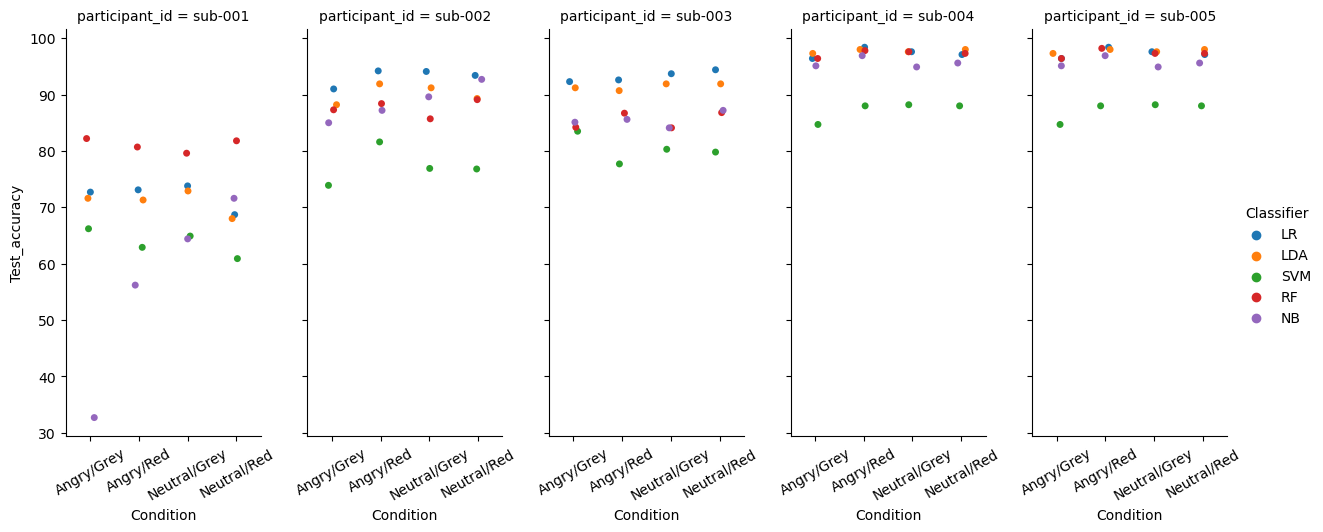

In [20]:
ax = sns.catplot(kind='strip', 
            data=acc_tab,
            y='Test_accuracy', x='Condition', hue='Classifier', col='participant_id',
            aspect=.5
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'accuracy_swarmplot_by_subj' + '.' + fig_format)

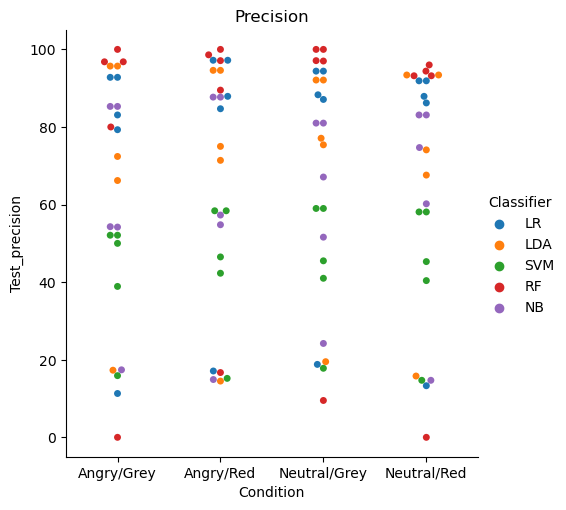

In [16]:
ax = sns.catplot(kind='swarm', 
                data=acc_tab,
                y='Test_precision', x='Condition', hue='Classifier'
                ).set(title='Precision')
ax.savefig(plot_stem + 'precision_swarmplot' + '.' + fig_format)

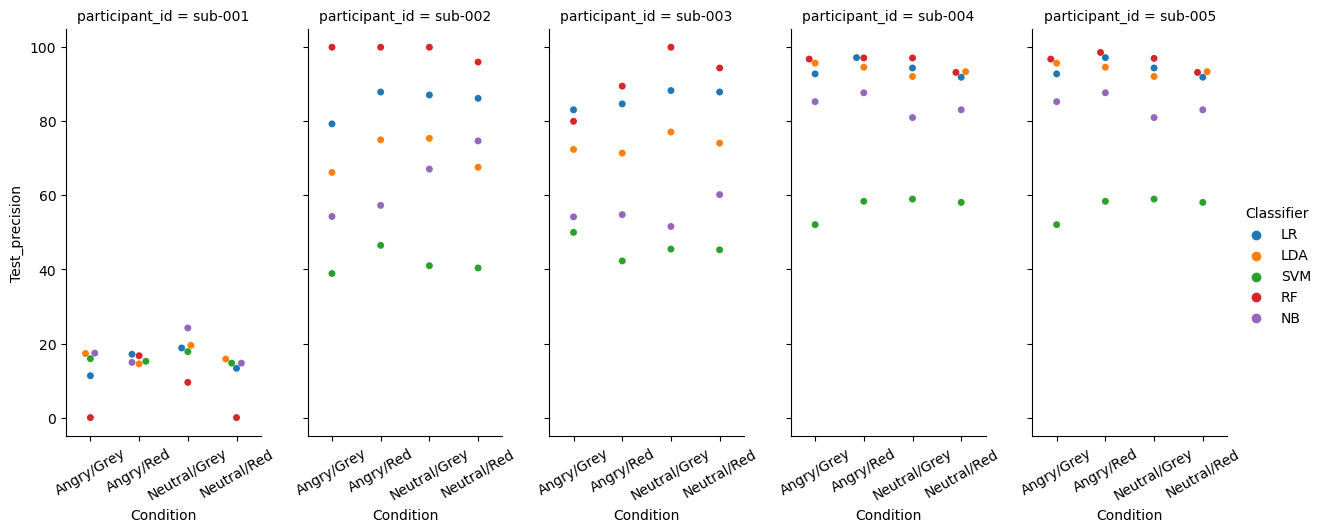

In [17]:
ax = sns.catplot(kind='swarm', 
            data=acc_tab,
            y='Test_precision', x='Condition', hue='Classifier', col='participant_id',
            aspect=.5
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'precision_swarmplot_by_subj' + '.' + fig_format)

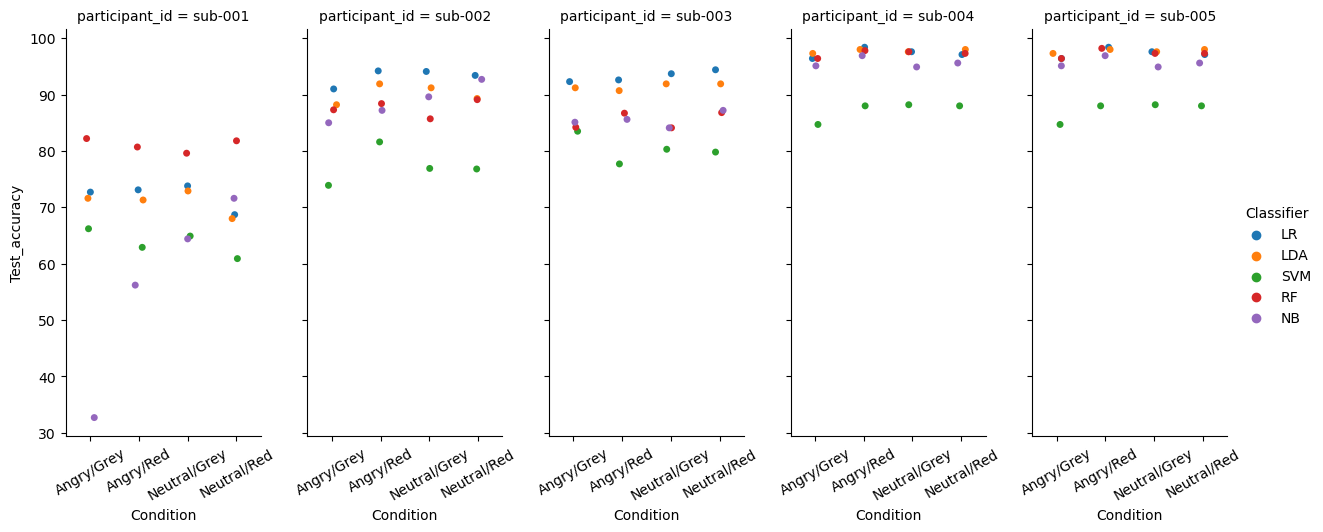

In [20]:
ax = sns.catplot(kind='strip', 
            data=acc_tab,
            y='Test_accuracy', x='Condition', hue='Classifier', col='participant_id',
            aspect=.5
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'accuracy_swarmplot_by_subj' + '.' + fig_format)

### Accuracy

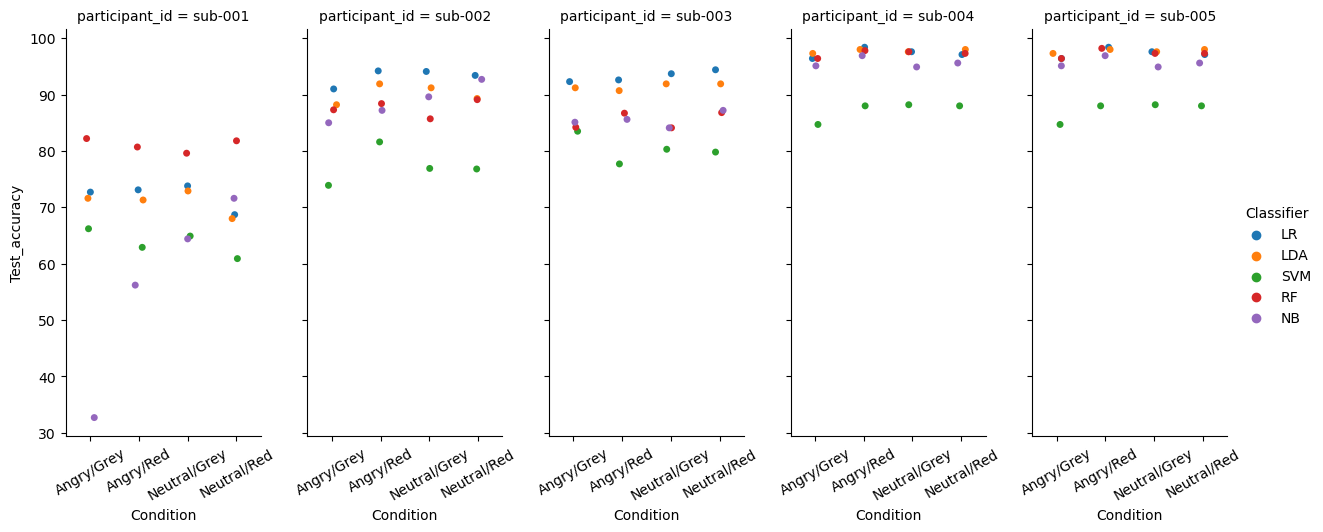

In [20]:
ax = sns.catplot(kind='strip', 
            data=acc_tab,
            y='Test_accuracy', x='Condition', hue='Classifier', col='participant_id',
            aspect=.5
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'accuracy_swarmplot_by_subj' + '.' + fig_format)

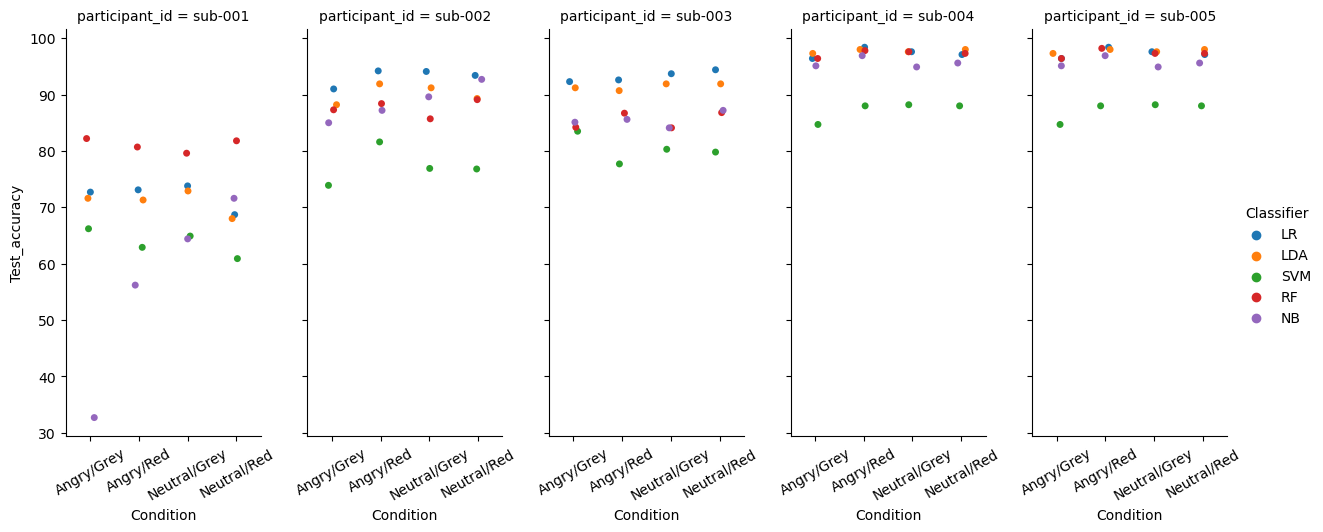

In [20]:
ax = sns.catplot(kind='strip', 
            data=acc_tab,
            y='Test_accuracy', x='Condition', hue='Classifier', col='participant_id',
            aspect=.5
            )
ax.set_xticklabels(rotation = 30)
ax.savefig(plot_stem + 'accuracy_swarmplot_by_subj' + '.' + fig_format)

### Read in stats 
Computed in `indiv_subj_analysis.ipynb`

In [21]:
# df_ttest = pd.read_csv('indiv_subj_ttests.csv', index_col='participant_id')

In [22]:
# df = pd.concat([acc_tab.filter(regex='Acc'),
#                 df_ttest],
#                axis=1
#               )
# df.to_csv('nagl_acc_ttests.csv', index=False)

In [23]:
# df.sort_values(by=['LDA Test Acc'], ascending=False).to_csv('nagl_ml_batch_summary_ordered.csv', 
#                                                index=False)

In [24]:
# df.sort_values(by=['LDA Test Acc'], ascending=False)